<a href="https://colab.research.google.com/github/efeecllk/Transformers/blob/main/micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
  return 3*x**2 + 5*x + 4

In [3]:
f(2.0)

26.0

In [4]:
xs = np.arange(-5,5,0.40)
xs

array([-5. , -4.6, -4.2, -3.8, -3.4, -3. , -2.6, -2.2, -1.8, -1.4, -1. ,
       -0.6, -0.2,  0.2,  0.6,  1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,
        3.8,  4.2,  4.6])

In [5]:
ys = f(xs)
ys

array([54.  , 44.48, 35.92, 28.32, 21.68, 16.  , 11.28,  7.52,  4.72,
        2.88,  2.  ,  2.08,  3.12,  5.12,  8.08, 12.  , 16.88, 22.72,
       29.52, 37.28, 46.  , 55.68, 66.32, 77.92, 90.48])

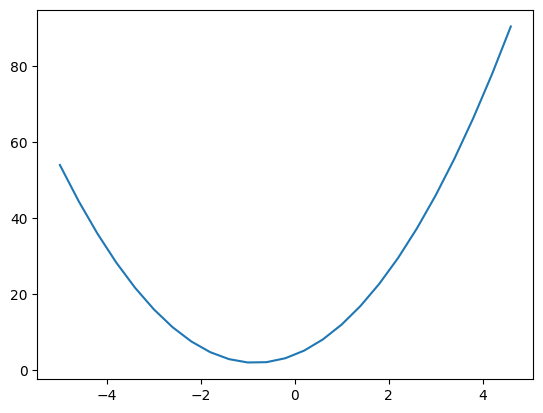

In [6]:
plt.plot(xs,ys)


In [7]:
class Value:
  def __init__(self, data, _children=(), _op='', label= ''):
    self.data = data
    self._prev = set(_children)
    self._op= _op
    self.label = label
    self.grad=0.0

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    out = Value(self.data + other.data, (self,other), '+')
    return out

  def __mul__(self,other):
    out = Value(self.data * other.data,(self,other), '*')
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self,), 'tanh')
    return out

a = Value(2.0, label='a')
b= Value(3.0, label = 'b')
c= Value(-4.0, label = 'c')
# a+b
# b.__add__(a)
e = a*b; e.label = 'e'
d= e+c; d.label = 'd'
# (a.__mul__(b)).__add__(c)

d

Value(data=2.0)

In [8]:
d._prev

{Value(data=-4.0), Value(data=6.0)}

In [9]:
d._op

'+'

In [10]:
#Visualize the Value and children
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label="{ %s |data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')

    if n._op:
      dot.node(name=uid + n._op, label=n._op)
      dot.edge(uid + n._op, uid)


  for n1, n2 in edges:

        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

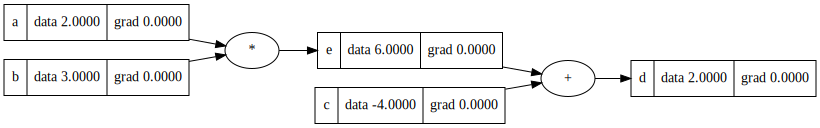

In [11]:
draw_dot(d)


In [12]:
# d.grad= 1

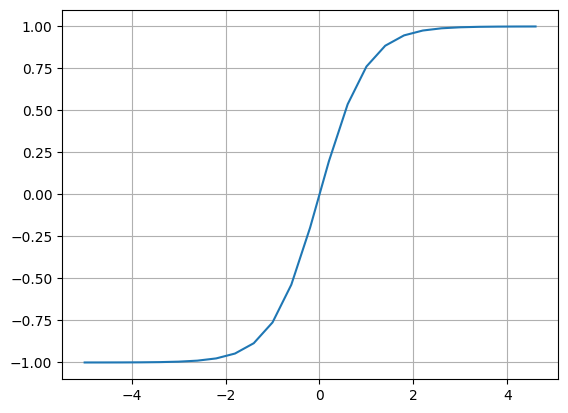

In [13]:
plt.plot(np.arange(-5,5,0.40), np.tanh(np.arange(-5,5,0.40))); plt.grid();


In [14]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w1
w1 = Value(-2.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(5.3, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label= 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'





In [15]:
o.grad = 1


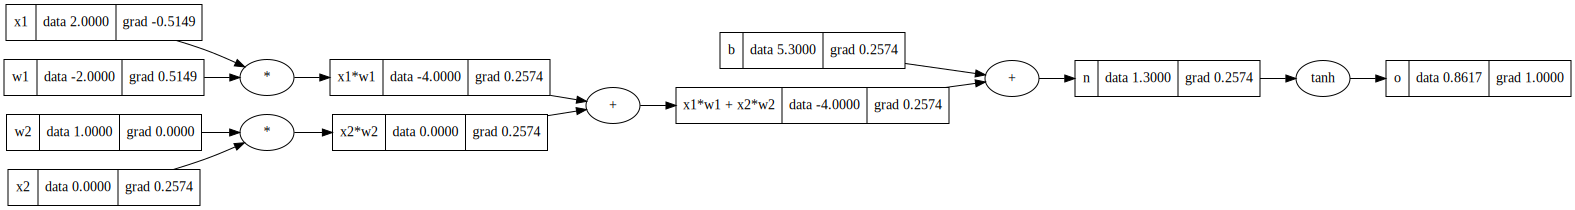

In [41]:
draw_dot(o)

In [17]:
# do/dn = 1 - tanh(n)**2
# o = tanh(n)
# do/dn = 1 - o**2

In [20]:
o.data


0.8617231593133063

In [22]:
n_grad = 1- o.data**2

In [23]:
n.grad = n_grad

In [27]:
x1w1x2w2.grad = n_grad
x1w1x2w2.grad

0.25743319670309406

In [28]:
b.grad = n_grad
b.grad

0.25743319670309406

In [37]:
x1w1.grad = n_grad
x2w2.grad = n_grad
x1w1.grad,x2w2.grad

(0.25743319670309406, 0.25743319670309406)

In [39]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x2.grad,w2.grad

(0.25743319670309406, 0.0)

In [38]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x1.grad, w1.grad

(-0.5148663934061881, 0.5148663934061881)